# Import packages

In [8]:
from keras.models import load_model
import os

import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency, visualize_saliency_with_losses
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

from pandas import read_csv
from numpy import dstack
from keras.utils import to_categorical

import math

os.mkdir('tmp')

# Read in the Trained Model

In [2]:
os.chdir('C:/Users/Liangyu/Desktop/BME725/Final Project/TestCNNLSTM/')
saved_model= load_model('CNN_LSTM_Test_2.h5')
#saved_model= load_model('cnnTest_1.h5')
saved_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 4, 30, 64)         1792      
_________________________________________________________________
time_distributed_47 (TimeDis (None, 4, 28, 64)         12352     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 4, 28, 64)         0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 4, 14, 64)         0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 4, 896)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               398800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)             

# Define the functions to load the dataset. Same as that in the training code

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# Load the dataset and reshape data into time bins

In [4]:
# load data
trainX, trainy, testX, testy = load_dataset()

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


# Take an example trial and show the four time bins

Text(0, 0.5, 'time in bin')

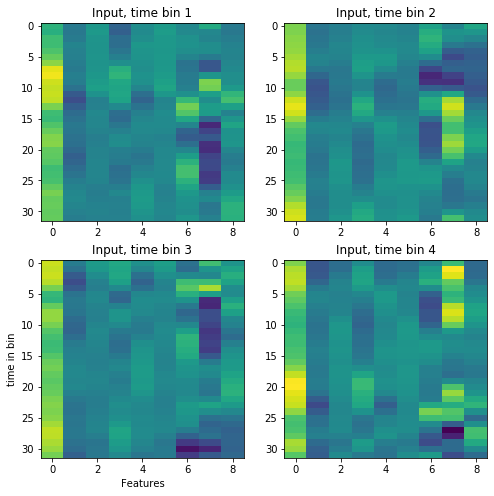

In [5]:
sampTrial = 100

# get image
imgTrain = trainX[sampTrial]

# normalize the colorbars for all of the time bins to the same range
vminInput=imgTrain.min()
vmaxInput=imgTrain.max()

# plot the sample trial
fig, (axs) = plt.subplots(2, 2, figsize = (8,8))
for i in range(0,4):
    axs[math.floor(i/2), i%2].imshow(imgTrain[i], aspect='auto', vmin=vminInput, vmax=vmaxInput)
    axs[math.floor(i/2), i%2].set_title('Input, time bin '+str(i+1))
axs[1, 0].set_xlabel('Features')
axs[1, 0].set_ylabel('time in bin')


# Compute the saliency map

In [6]:
# choose the layer that whose output you want to set as dy
layer_idx = utils.find_layer_idx(saved_model, 'dense_20')
# change the activation function of that layer to linear
saved_model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(saved_model)

# compute saliency map
grads = visualize_saliency(model, layer_idx, filter_indices=None, \
                           seed_input=imgTrain, backprop_modifier=None, \
                           grad_modifier = "absolute", keepdims=True)

# Plot the both the input and the saliency maps to visualize the affect of each pixel in the input on the chosen model layer

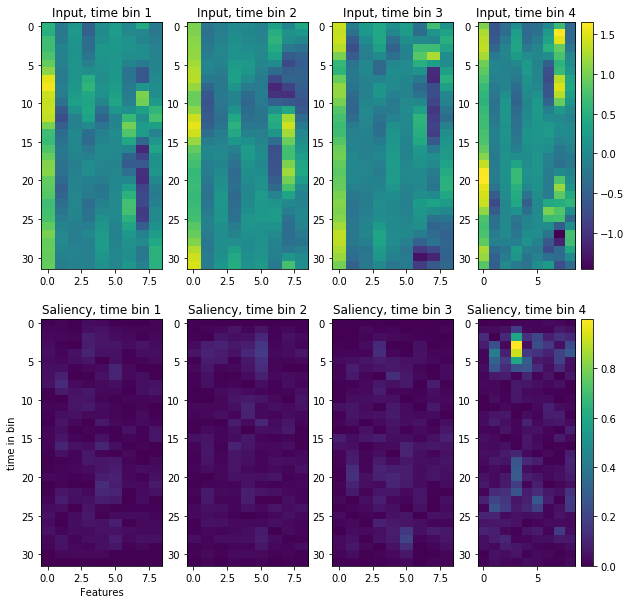

In [7]:
# normalize the colorbars for all of the time bins to the same range
vminInput=imgTrain.min()
vmaxInput=imgTrain.max()
vminSaliency=grads.min()
vmaxSaliency=grads.max()  

fig, axs = plt.subplots(2, 4, figsize = (10,10))
for i in range(0,4):
    p1 = axs[0, i].imshow(imgTrain[i], aspect='auto', vmin=vminInput, vmax=vmaxInput);
    axs[0, i].set_title('Input, time bin '+str(i+1))
    p2 = axs[1, i].imshow(grads[i], aspect='auto', vmin=vminSaliency, vmax=vmaxSaliency);
    axs[1, i].set_title('Saliency, time bin '+str(i+1))
    if i == 0:
        axs[1, i].set_xlabel('Features')
        axs[1, i].set_ylabel('time in bin')
    if i==3:
        cb1 = plt.colorbar(p1, ax=axs[0, i])
        cb2 = plt.colorbar(p2, ax=axs[1, i], panchor=False)
        

plt.show()